# Visualization of CNN Layers and Filters

## Outline
1. Using torchvision.datasets with a custom folder of images
2. Occlusion analysis with pretrained model
3. Filter visualisation with pretrained model

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

## Load dataset

In [0]:
#reading the labels of data we uploaded
with open("data/imagenet_labels.txt") as f:
    classes = eval(f.read())

In [0]:
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

In [0]:
#defining the transformations for the data

# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     #normalize the images with imagenet data mean and std
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

In [0]:
#define the data we uploaded as evaluation data and apply the transformations

# evalset = torchvision.datasets.ImageFolder(root = "./data/imagenet", transform = transform)

In [3]:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader

class trainset(Dataset):
    def __init__(self):
        
        root = "./data2/"
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk("./data2/"):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    self.label_list.append(int(root[13:]))
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
#         print(path)
#         data = []
#         label = []
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
#         data = np.asarray(Image.open(path))
        label= self.label_list[index] 
#         print(data.shape)
#         data = np.asarray(data)
        label = np.asarray(label)
        
        return data, label
dataloader = trainset()
data,label = dataloader.__getitem__(5)

2000 2000


In [63]:
#create a data loader for evaluation

batch_size=16 #batch size
# evalloader = torch.utils.data.DataLoader(evalset, batch_size = batch_size, shuffle = True)
evalloader = torch.utils.data.DataLoader(trainset(), batch_size=batch_size)
dataiter = iter(evalloader)

2000 2000


In [34]:
#looking at data using iter

# dataiter = iter(evalloader)
images, labels = dataiter.next()

#shape of images bunch
print(images.shape)
#shape of single image in a bunch
print(images[0].shape)

#label of the image
print(labels[0].item())

torch.Size([1, 1, 128, 431])
torch.Size([1, 128, 431])
36


## Load pretrained model

In [66]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 9)
        self.pool = nn.MaxPool2d(30, 30)
        self.fc1 = nn.Linear(896, 256)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,56)
        self.fc4 = nn.Linear(56,50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [67]:
#for visualization we will use vgg16 pretrained on imagenet data

model = torch.load("./toy_model_20.pt")

In [54]:
model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=30, stride=30, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=896, out_features=256, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)

## Visualise image

In [186]:
def imshow(img, title):
    
  #define std correction to be made
#   std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  
  #define mean correction to be made
#   mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  
  #convert the tensor img to numpy img and de normalize 
#   npimg = np.multiply(img.numpy(), std_correction) + mean_correction
    npimg = img
    plt.figure(figsize = (batch_size * 4, 4))
    plt.axis("off")
#     print(np.transpose(npimg, (1, 2, 0)).shape)
    img = np.transpose(npimg, (1, 2, 0))
#     print(img.to_array())
    plt.imshow(img)
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.title(title)
    plt.show()

In [234]:
#custom function to fetch images from dataloader

def show_batch_images(dataloader):
    
    images,_ = next(iter(dataloader))
    print(images.shape)
  #run the model on the images
    outputs = model(images)

  #get the maximum class 
    _, pred = torch.max(outputs.data, 1)
#   print(images.shape)
#     images = t
    res = []
#     for i in range(batch_size):
# #         print(images[i,0,:,:].shape)
#         min_val = torch.min(images[i,0,:,:])
#         max_val = torch.max(images[i,0,:,:])
#         nor_data = (images[i,:,:,:] - min_val) *255/(max_val-min_val)
#         res.append(nor_data)
#     res = torch.cat(res, 0)
#     res = res.unsqueeze(1)
#     res = res.repeat(1,3, 1, 1)
#     print(res.shape)
  #make grid
#     print(res)
#     images = images.repeat(1,3,1,1)
    img = torchvision.utils.make_grid(images, normalize=True,scale_each=True)
#     img = torchvision.utils.make_grid(res, normalize=True)
    print(img.shape)
  #call the function
#   imshow(img, title=[classes[x.item()] for x in pred])
#     print(img.shape)
    imshow(img, "1")

    return images, pred

torch.Size([16, 1, 128, 431])


/Users/xixi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([3, 262, 3466])


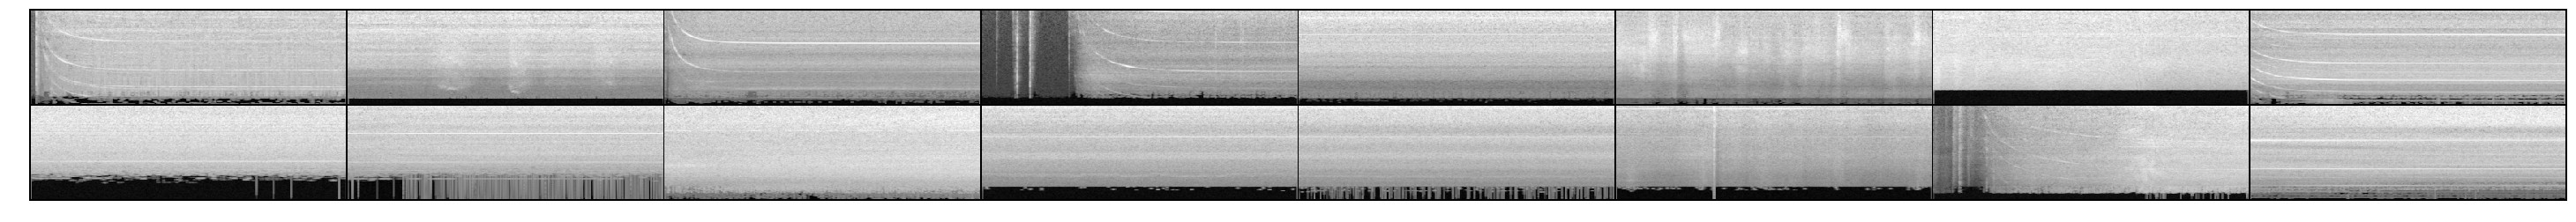

In [235]:
images, pred = show_batch_images(evalloader)

## Occlusion analysis

In [194]:
#running inference on the images without occlusion

#vgg16 pretrained model
outputs = model(images)
print(outputs.shape)

#passing the outputs through softmax to interpret them as probability
outputs = nn.functional.softmax(outputs, dim = 1)

#getting the maximum predicted label
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

print(prob_no_occ)

torch.Size([16, 50])
0.052550580352544785


/Users/xixi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [195]:
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [206]:
# heatmap = occlusion(model, images, pred[0].item(), 32, 14)

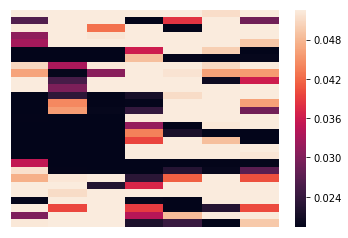

In [197]:
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
figure.savefig('svm_conf.png', dpi=400)

## Filter visualisation

In [207]:
#for filter visualization, we will use alexnet pretrained with imagenet data
model = torch.load("./toy_model_20.pt")
print(model)
# alexnet = models.alexnet(pretrained=True)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=30, stride=30, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=896, out_features=256, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=56, bias=True)
  (fc4): Linear(in_features=56, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)


In [4]:
from vis_filters import plot_weights
plot_weights(model, 0, single_channel = True)

ImportError: cannot import name 'plot_weights'

In [199]:
def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

In [200]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [201]:
def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [238]:
def plot_weights(model, layer_num, single_channel = True, collated = False):
  
  #extracting the model features at the particular layer number
  #checking whether the layer is convolution layer or not 

    #getting the weight tensor data
    weight_tensor = nn.Sequential(*list(model.children())[:4])[layer_num].weight.data
    
    print(images.shape)
    images = torch.from_numpy(images)
    output = model.conv1(images)
    print(output)
    
    if single_channel:
        if collated:
            plot_filters_single_channel_big(weight_tensor)
        else:
            plot_filters_single_channel(weight_tensor)
        
    else:
        if weight_tensor.shape[1] == 3:
            plot_filters_multi_channel(weight_tensor)
        else:
            print("Can only plot weights with three channels with single channel = False")
        
#     else:
#     print("Can only visualize layers which are convolutional")

In [239]:
#visualize weights for alexnet - first conv layer
# for i in model.children():
#     print(i.weight.data)
# print(nn.Sequential(*list(model.children())[:4])[0].weight.data)
plot_weights(model, 0, single_channel = True)

(1, 128, 431)


RuntimeError: Expected 4-dimensional input for 4-dimensional weight 16 1 9 9, but got 3-dimensional input of size [1, 128, 431] instead

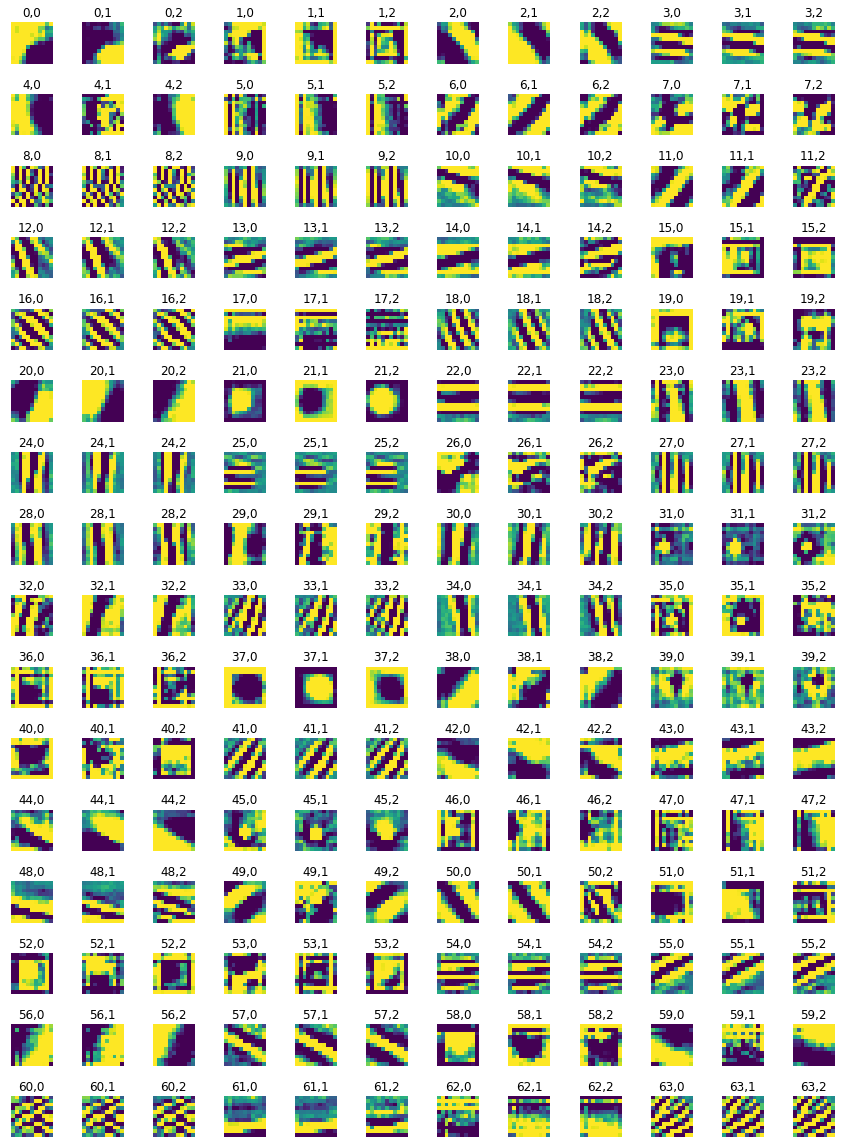

In [0]:
#plotting single channel images

plot_weights(alexnet, 0, single_channel = True)

In [0]:
#plot for 3rd layer -> 2nd conv layer
plot_weights(alexnet, 3, single_channel = True)

In [0]:
 plot_weights(alexnet, 0, single_channel = True, collated = True)

In [0]:
plot_weights(alexnet, 3, single_channel = True, collated = True)

In [0]:
plot_weights(alexnet, 6, single_channel = True, collated = True)

In [0]:
#for vgg16

plot_weights(model, 0, single_channel = True, collated = True)

In [0]:
plot_weights(model, 2, single_channel = True, collated = True)

In [0]:
plot_weights(model, 5, single_channel = True, collated = True)

In [0]:
plot_weights(model, 0, single_channel = False, collated = False)